In [1]:
# Inspired by https://www.kaggle.com/ashwani07/mnist-classification-using-random-forest

In [2]:
import requests
from pathlib import Path

In [3]:
import sys
print(sys.version)

3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


## Download Dataset

In [4]:
mnist_file = 'mnist.csv'
mnist_file_path = Path(mnist_file)
if not mnist_file_path.is_file():
    # file exists
    print('Dataset does not exist. Downloading...')
    csv_url = 'https://raw.githubusercontent.com/MSc-in-Data-Science/class_material/master/semester_1/Machine_Learning/datasets/digit_recognizer_dataset.csv'
    req = requests.get(csv_url)
    url_content = req.content
    csv_file = open('mnist.csv', 'wb')

    csv_file.write(url_content)
    csv_file.close()
    print('Dataset Downloaded')
else:
    print('Dataset exists')

Dataset exists


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [6]:
#Load other modules
import matplotlib.pyplot as plt  #Graphics
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.model_selection import cross_val_score
#To show graphs within the notebook
%matplotlib inline 

In [7]:
#load the datasets
train = pd.read_csv("mnist.csv")
# test = pd.read_csv("../input/test.csv")

In [8]:
#Printing the size of the dataframe
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
# print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))

Training dataset has 42000 observations and 785 variables


In [9]:
#check few rows
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]

In [11]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(28,28).astype('uint8')
    plt.imshow(temp)

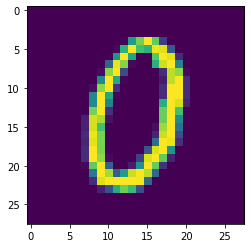

In [12]:
print_image(5, df_x)

In [13]:
#Check the frequency of each number
df_y.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

C:\Users\skoul\Documents\bouzios_ml\machine_learning_master_2020\exercise_2\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

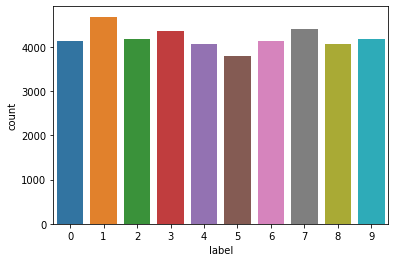

In [14]:
sns.countplot(df_y)

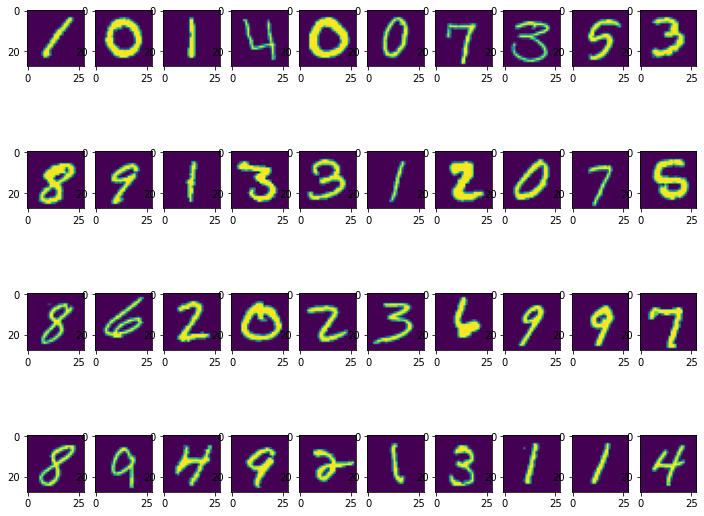

In [15]:
plt.figure(figsize=(12,10))
for i in range(40):
    plt.subplot(4, 10, i+1)
    print_image(i, df_x)

In [16]:
#Split the dataset
df_x = df_x.astype('int32')
df_y = df_y.astype('int32')

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)

(29400, 784)
(12600, 784)


In [17]:
# for col in df_x.columns:
#     if len(df_x[col].unique()) == 1:
#         df_x.drop(col,inplace=True,axis=1)
        
# print(X_train.shape)
# print(X_test.shape)

## Feature Selection or Reduction

In [18]:
df_new= X_train.dropna()
df_new

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
26437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA

In [20]:
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=100)
pca.fit(X_train)

X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)


## Feature Selection

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best_features = SelectKBest(score_func=chi2, k=200)
fit = best_features.fit(X_train, y_train)
X_train_new = fit.transform(X_train)
X_test_new = fit.transform(X_test)



In [34]:
#training random Forest
# rf=RandomForestClassifier(n_estimators=100)
# rf.fit(X_train_new,y_train)

# from sklearn.ensemble import AdaBoostClassifier

# num_trees = 100
# seed=7
# rf = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
# rf.fit(X_train,y_train)

# from sklearn import datasets, svm, metrics
# rf = svm.SVC(C=200,kernel='rbf',gamma=0.01,cache_size=8000,probability=False)
# rf.fit(X_train_new,y_train)

from sklearn.neighbors import KNeighborsClassifier
rf = KNeighborsClassifier()
rf.fit(X_train_new ,y_train)


KNeighborsClassifier()

In [35]:
pred=rf.predict(X_test_new)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1242
           1       0.95      0.99      0.97      1429
           2       0.97      0.94      0.96      1276
           3       0.94      0.92      0.93      1298
           4       0.90      0.81      0.85      1236
           5       0.93      0.91      0.92      1119
           6       0.97      0.97      0.97      1243
           7       0.94      0.96      0.95      1334
           8       0.97      0.91      0.94      1204
           9       0.81      0.91      0.85      1219

    accuracy                           0.93     12600
   macro avg       0.93      0.93      0.93     12600
weighted avg       0.93      0.93      0.93     12600

Confusion Report
[[1224    0    1    0    2    1    9    1    2    2]
 [   0 1415    2    3    1    0    3    3    1    1]
 [  10   10 1203    4    3    2    0   35    8    1]
 [   2    5   12 1200    2   47    0   19  

from sklearn.metrics import confusion_matrix

cmrforest = confusion_matrix(y_test , pred)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
rf.score(X_test_new,y_test)

## CV

In [25]:
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=100)
pca.fit(df_x)

df_x_new = pca.fit_transform(df_x)


In [26]:
#Cross validation
rf=RandomForestClassifier(n_estimators=100)
rf.fit(df_x_new, df_y)
score = cross_val_score(rf, df_x_new, df_y)
print (np.mean(score))

0.9449285714285715


In [ ]:
## TODO: Tune algorithm, show 9 missclassified as 4